<a href="https://colab.research.google.com/github/uday-andotra/WQU/blob/main/WQU_Financial_Data_Group_Work_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Group Work Project # 2

##Group Members : Geoffrey Gacemi Ngeru, Collins Atambo and Udayveer Singh Andotra.


#Part 1. Assessing Models with Alternative Data

In [ ]:
# config
FUND = "ECH"                 # Choose from: "ECH", "EWZ", "IVV"
TICKERS = {"ECH": "ECH", "EWZ": "EWZ", "IVV": "IVV"}  # Yahoo tickers
START = "2009-12-12"
END   = "2020-01-01"         # paper's window (pre-pandemic)
TARGET = "Open"              # we predict next-day Open direction, like the paper
SEED = 42
print(f"Using {FUND} ({TICKERS[FUND]}) from {START} to {END}")


Using ECH (ECH) from 2009-12-12 to 2020-01-01


In [ ]:
# data download
!pip -q install yfinance pandas_ta scikit-learn matplotlib

import yfinance as yf
import pandas as pd
import numpy as np

raw = yf.download(TICKERS[FUND], start=START, end=END, auto_adjust=False, progress=False)
raw = raw.dropna()
raw.head()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompa

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ECH,ECH,ECH,ECH,ECH,ECH
Date,,,,,,
2009-12-14,36.614761,54.540001,54.770000,53.900002,54.099998,212300
2009-12-15,36.487198,54.349998,54.580002,54.250000,54.250000,122100
2009-12-16,36.527489,54.410000,55.000000,54.299999,55.000000,201500
2009-12-17,36.393208,54.209999,54.320000,53.599998,53.639999,72300
2009-12-18,36.514065,54.389999,54.509998,53.500000,54.509998,104900


In [ ]:
!pip -q install --upgrade --no-cache-dir scikit-learn>=1.5.0


In [ ]:
import pandas as pd

if isinstance(raw.columns, pd.MultiIndex):
    # Keep only the top level names (Adj Close, Close, High, Low, Open, Volume)
    raw = raw.copy()
    raw.columns = raw.columns.get_level_values(0)
raw.head()


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2009-12-14,36.614761,54.540001,54.770000,53.900002,54.099998,212300
2009-12-15,36.487198,54.349998,54.580002,54.250000,54.250000,122100
2009-12-16,36.527489,54.410000,55.000000,54.299999,55.000000,201500
2009-12-17,36.393208,54.209999,54.320000,53.599998,53.639999,72300
2009-12-18,36.514065,54.389999,54.509998,53.500000,54.509998,104900


In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta

df = raw.copy()

# 1) Indicators (append to df)
df.ta.rsi(close="Close", length=14, append=True)
df.ta.stoch(high="High", low="Low", close="Close", k=14, d=3, smooth_k=3,
             mamode="sma", append=True)
df.ta.sma(close="Close", length=10, append=True)
df.ta.ema(close="Close", length=12, append=True)
df.ta.adx(high="High", low="Low", close="Close", length=14, append=True)
df.ta.atr(high="High", low="Low", close="Close", length=14, append=True)
df.ta.bbands(close="Close", length=20, std=2.0, append=True)
df.ta.obv(close="Close", volume="Volume", append=True)

# 2) Resolve column names that vary across pandas-ta versions
def first_existing(cols): return next((c for c in cols if c in df.columns), None)
colmap = {
    "RSI_14": "RSI_14",
    "StochK": first_existing(["STOCHk_14_3_3","STOCHk_14_3_3.0"]),
    "StochD": first_existing(["STOCHd_14_3_3","STOCHd_14_3_3.0"]),
    "SMA_10": "SMA_10",
    "EMA_12": "EMA_12",
    "ADX_14": first_existing(["ADX_14","ADX_14_14"]),
    "ATR_14": first_existing(["ATR_14","ATRr_14"]),
    "BBP":    first_existing(["BBP_20_2.0","%B_20_2.0","BBP_20_2"]),
    "OBV":    "OBV"
}
resolved = {a:s for a,s in colmap.items() if s and s in df.columns}
base_cols = ["Open","High","Low","Close","Adj Close","Volume"]

# 3) Keep OHLCV + indicators; rename to stable aliases
df = df[base_cols + list(resolved.values())].copy()
df.rename(columns={v:k for k,v in resolved.items()}, inplace=True)

# 4) Label: next-day Open direction
df["Gamma"] = np.where(df["Open"].shift(-1) - df["Open"] > 0, 1, -1)
df = df.dropna().iloc[:-1, :]  # drop lookback NaNs and last row

X = df[base_cols + list(resolved.keys())].copy()
y = df["Gamma"].copy()

# 5) Min–max scale by hand (no sklearn)
X_scaled = (X - X.min()) / (X.max() - X.min())
X_scaled = X_scaled.fillna(0.0).clip(0, 1)

# 6) Easy metrics
y01 = (y == 1).astype(int)
pearson_scores = X_scaled.apply(lambda s: s.corr(y01), axis=0).abs().sort_values(ascending=False)

def dispersion_ratio(series):
    abs_dev = (series - series.median()).abs()
    mean_dev = abs_dev.mean()
    med_dev  = abs_dev.median() if pd.notna(abs_dev.median()) and abs_dev.median()!=0 else 1e-12
    return float(mean_dev / med_dev)

dr_scores = X_scaled.apply(dispersion_ratio, axis=0).sort_values(ascending=False)

print("Indicators used:", [c for c in X.columns if c not in base_cols])
print("\nTop 10 by |Pearson|:\n", pearson_scores.head(10))
print("\nTop 10 by Dispersion Ratio:\n", dr_scores.head(10))

# Keep for later cells
_ = (X_scaled, y, pearson_scores, dr_scores)


Indicators used: ['RSI_14', 'StochK', 'StochD', 'SMA_10', 'EMA_12', 'ADX_14', 'ATR_14', 'OBV']

Top 10 by |Pearson|:
 Price
RSI_14       0.203152
StochK       0.116383
StochD       0.049760
Adj Close    0.021803
Close        0.021571
ATR_14       0.013743
Low          0.011127
High         0.009417
OBV          0.007648
Volume       0.005914
dtype: float64

Top 10 by Dispersion Ratio:
 Price
ATR_14    1.487511
Volume    1.459960
ADX_14    1.192379
SMA_10    1.188000
Close     1.185457
Low       1.185005
Open      1.179607
High      1.178507
EMA_12    1.174114
RSI_14    1.148704
dtype: float64


In [ ]:

import numpy as np
import pandas as pd

# 0) Pull objects from bullet 3
X_scaled, y, pearson_scores, dr_scores = _

# 1) Select features by consensus: top quartile of Pearson and DR
q = 0.25
top_p = set(pearson_scores.index[:max(1, int(len(pearson_scores)*q))])
top_d = set(dr_scores.index[:max(1, int(len(dr_scores)*q))])
selected = sorted(top_p.intersection(top_d))
if not selected:
    selected = list(pearson_scores.index[:5])  # fallback if intersection is empty
print("Selected (Pearson ∩ DR):", selected)

# Prepare matrices
base_cols = ["Open","High","Low","Close","Adj Close","Volume"]
all_cols  = list(X_scaled.columns)                   # full set
sel_cols  = selected if selected else all_cols[:5]   # guard

X_full = X_scaled[all_cols].values.astype(float)
X_sel  = X_scaled[sel_cols].values.astype(float)
y_arr  = (y.values == 1).astype(int)  # map {-1,1} -> {0,1}

# 2) Simple stratified K-fold splitter (no sklearn)
def stratified_kfold_indices(y, k=10, seed=42):
    rng = np.random.default_rng(seed)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    rng.shuffle(idx_pos); rng.shuffle(idx_neg)
    pos_folds = np.array_split(idx_pos, k)
    neg_folds = np.array_split(idx_neg, k)
    folds = [np.sort(np.concatenate([p, n])) for p, n in zip(pos_folds, neg_folds)]
    return folds

# 3) Minimal logistic regression (batch GD) with L2 regularization
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def fit_logreg(X, y, lr=0.1, iters=2000, reg=1e-4):
    # add bias
    Xb = np.c_[np.ones((X.shape[0], 1)), X]
    w  = np.zeros(Xb.shape[1])
    for _ in range(iters):
        p = sigmoid(Xb @ w)
        grad = Xb.T @ (p - y) / Xb.shape[0] + reg * np.r_[0, w[1:]]  # no reg on bias
        w -= lr * grad
    return w

def predict_logreg(X, w):
    Xb = np.c_[np.ones((X.shape[0], 1)), X]
    return (sigmoid(Xb @ w) >= 0.5).astype(int)

def kfold_cv_accuracy(X, y, k=10, seed=42, **train_kwargs):
    folds = stratified_kfold_indices(y, k=k, seed=seed)
    accs = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.setdiff1d(np.arange(len(y)), val_idx)
        w = fit_logreg(X[train_idx], y[train_idx], **train_kwargs)
        preds = predict_logreg(X[val_idx], w)
        accs.append((preds == y[val_idx]).mean())
    return np.array(accs)

# 4) Run CV for Full vs Selected features
acc_full = kfold_cv_accuracy(X_full, y_arr, k=10, seed=42, lr=0.15, iters=2500, reg=1e-4)
acc_sel  = kfold_cv_accuracy(X_sel,  y_arr, k=10, seed=42, lr=0.15, iters=2500, reg=1e-4)

print(f"Full features (n={X_full.shape[1]}):  mean={acc_full.mean():.4f}  std={acc_full.std():.4f}")
print(f"Selected (n={X_sel.shape[1]}):       mean={acc_sel.mean():.4f}   std={acc_sel.std():.4f}")

# Keep for later bullets (table & plots)
cv_results = {
    "Feature Set": ["Full", "Selected (Pearson∩DR)"],
    "Num Features": [X_full.shape[1], X_sel.shape[1]],
    "Mean Acc": [acc_full.mean(), acc_sel.mean()],
    "Std Acc":  [acc_full.std(),  acc_sel.std()],
    "Fold Accuracies Full": acc_full,
    "Fold Accuracies Sel":  acc_sel,
    "Selected Columns": sel_cols
}
cv_results


Selected (Pearson ∩ DR): ['RSI_14', 'StochK', 'StochD', 'Adj Close', 'Close']
Full features (n=14):  mean=0.6428  std=0.0297
Selected (n=5):       mean=0.6380   std=0.0288


{'Feature Set': ['Full', 'Selected (Pearson∩DR)'],
 'Num Features': [14, 5],
 'Mean Acc': [np.float64(0.6427709606020363), np.float64(0.6379948270410422)],
 'Std Acc': [np.float64(0.029731526024030935),
  np.float64(0.028784109072732628)],
 'Fold Accuracies Full': array([0.61904762, 0.6031746 , 0.66666667, 0.6812749 , 0.62948207,
        0.67330677, 0.62151394, 0.68924303, 0.616     , 0.628     ]),
 'Fold Accuracies Sel': array([0.59920635, 0.60714286, 0.67063492, 0.67330677, 0.63346614,
        0.66533865, 0.61354582, 0.67330677, 0.608     , 0.636     ]),
 'Selected Columns': ['RSI_14', 'StochK', 'StochD', 'Adj Close', 'Close']}

In [ ]:

import pandas as pd
import numpy as np

# pull from earlier cells
X_scaled, y, pearson_scores, dr_scores = _
res = cv_results

# 1) CV summary table (Full vs Selected)
summary = pd.DataFrame({
    "Feature Set": res["Feature Set"],
    "Num Features": res["Num Features"],
    "Mean Acc": [float(res["Mean Acc"][0]), float(res["Mean Acc"][1])],
    "Std Acc":  [float(res["Std Acc"][0]),  float(res["Std Acc"][1])]
})
display(summary)

# save CSV
fund = globals().get("FUND", "FUND")
summary_csv = f"{fund}_cv_summary.csv"
summary.to_csv(summary_csv, index=False)
print("Saved summary CSV ->", summary_csv)

# 2) Selected-features table with |Pearson| + Dispersion Ratio
sel_cols = res["Selected Columns"]
feat_table = pd.DataFrame({
    "Feature": sel_cols,
    "|Pearson|": [abs(pearson_scores.get(c, np.nan)) for c in sel_cols],
    "Dispersion Ratio": [dr_scores.get(c, np.nan) for c in sel_cols]
}).sort_values("|Pearson|", ascending=False)

display(feat_table)

sel_csv = f"{fund}_selected_features.csv"
feat_table.to_csv(sel_csv, index=False)
print("Saved selected-features CSV ->", sel_csv)



,Feature Set,Num Features,Mean Acc,Std Acc
0,Full,14,0.642771,0.029732
1,Selected (Pearson∩DR),5,0.637995,0.028784


Saved summary CSV -> ECH_cv_summary.csv


,Feature,|Pearson|,Dispersion Ratio
0,RSI_14,0.203152,1.148704
1,StochK,0.116383,0.929718
2,StochD,0.049760,0.929467
3,Adj Close,0.021803,1.108188
4,Close,0.021571,1.185457


Saved selected-features CSV -> ECH_selected_features.csv


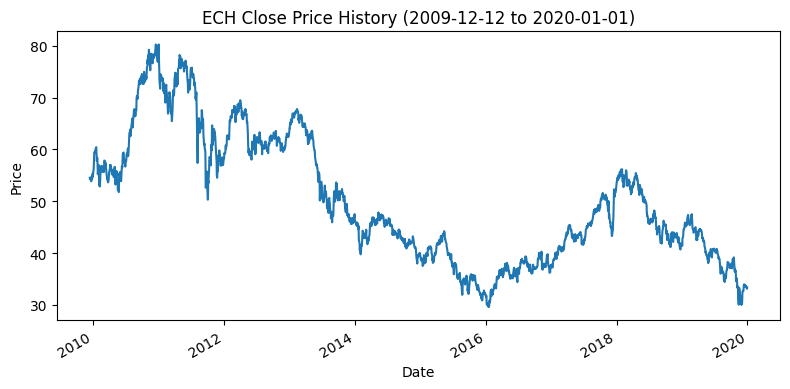

Saved: ECH_price_history.png


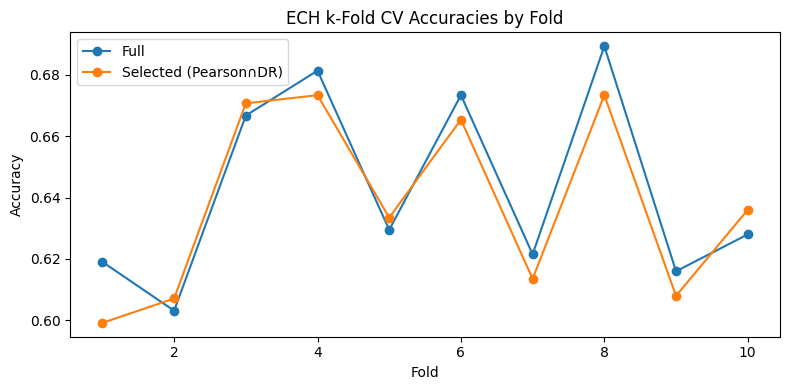

Saved: ECH_cv_accuracies.png


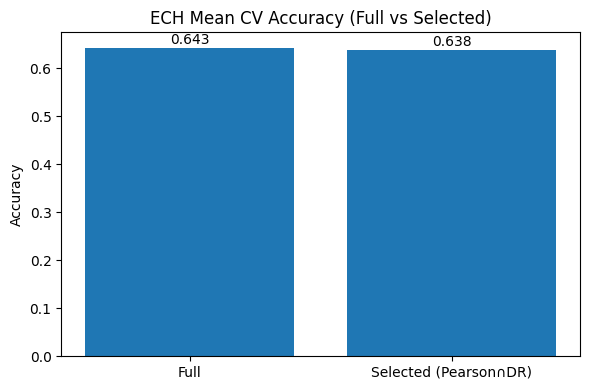

Saved: ECH_cv_mean_compare.png


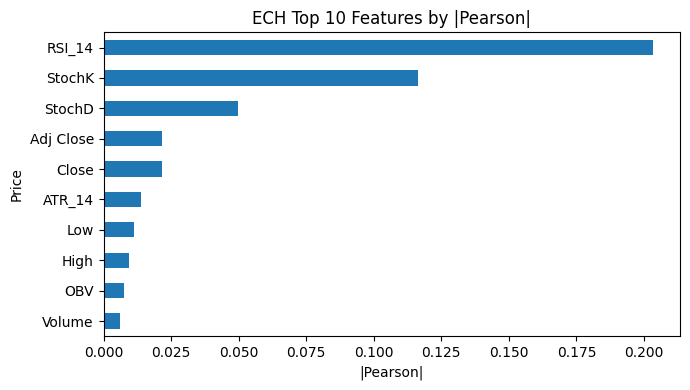

Saved: ECH_top_pearson.png


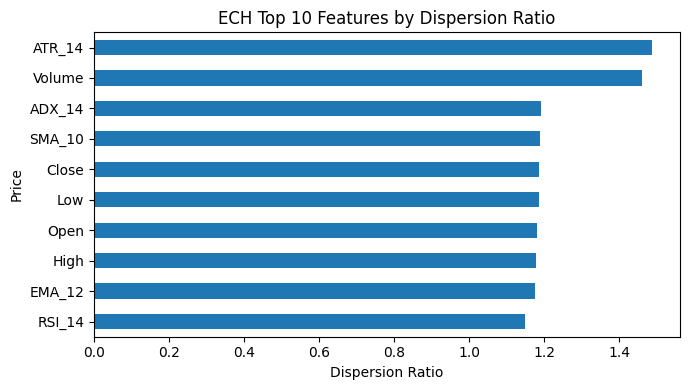

Saved: ECH_top_dr.png


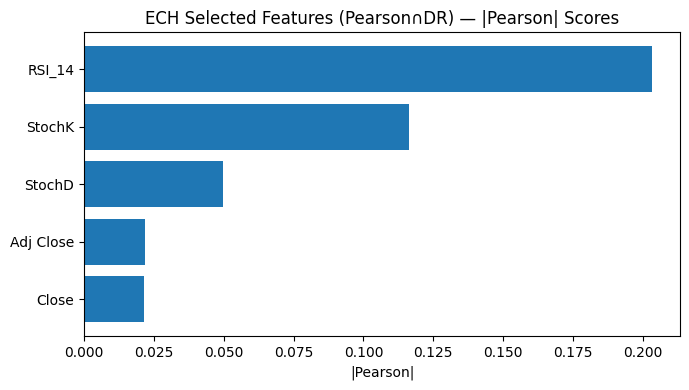

Saved: ECH_selected_features_bar.png


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pull what we built earlier
fund = globals().get("FUND", "FUND")
START = globals().get("START", "")
END   = globals().get("END", "")
acc_full = cv_results["Fold Accuracies Full"]
acc_sel  = cv_results["Fold Accuracies Sel"]
sel_cols = cv_results["Selected Columns"]

# 1) Price history (Close)
fig1_path = f"{fund}_price_history.png"
plt.figure(figsize=(8,4))
raw["Close"].plot()
plt.title(f"{fund} Close Price History ({START} to {END})")
plt.xlabel("Date"); plt.ylabel("Price")
plt.tight_layout(); plt.savefig(fig1_path, dpi=150); plt.show()
print("Saved:", fig1_path)

# 2) Per-fold CV accuracies (Full vs Selected)
fig2_path = f"{fund}_cv_accuracies.png"
plt.figure(figsize=(8,4))
x = np.arange(1, len(acc_full)+1)
plt.plot(x, acc_full, marker="o", label="Full")
plt.plot(x, acc_sel,  marker="o", label="Selected (Pearson∩DR)")
plt.title(f"{fund} k-Fold CV Accuracies by Fold")
plt.xlabel("Fold"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout(); plt.savefig(fig2_path, dpi=150); plt.show()
print("Saved:", fig2_path)

# 3) Mean accuracy comparison (bar chart)
fig3_path = f"{fund}_cv_mean_compare.png"
plt.figure(figsize=(6,4))
means = [acc_full.mean(), acc_sel.mean()]
labels = ["Full", "Selected (Pearson∩DR)"]
plt.bar(labels, means)
plt.title(f"{fund} Mean CV Accuracy (Full vs Selected)")
plt.ylabel("Accuracy")
for i,v in enumerate(means):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout(); plt.savefig(fig3_path, dpi=150); plt.show()
print("Saved:", fig3_path)

# 4) Feature importance visuals (top by |Pearson| and by Dispersion Ratio)
topN = min(10, len(pearson_scores))
fig4a_path = f"{fund}_top_pearson.png"
plt.figure(figsize=(7,4))
pearson_scores.head(topN).iloc[::-1].plot(kind="barh")
plt.title(f"{fund} Top {topN} Features by |Pearson|")
plt.xlabel("|Pearson|")
plt.tight_layout(); plt.savefig(fig4a_path, dpi=150); plt.show()
print("Saved:", fig4a_path)

topN = min(10, len(dr_scores))
fig4b_path = f"{fund}_top_dr.png"
plt.figure(figsize=(7,4))
dr_scores.head(topN).iloc[::-1].plot(kind="barh")
plt.title(f"{fund} Top {topN} Features by Dispersion Ratio")
plt.xlabel("Dispersion Ratio")
plt.tight_layout(); plt.savefig(fig4b_path, dpi=150); plt.show()
print("Saved:", fig4b_path)

# 5) (Optional) Highlight only the actually selected features on |Pearson|
fig5_path = f"{fund}_selected_features_bar.png"
sel_df = pd.DataFrame({
    "Feature": sel_cols,
    "|Pearson|": [abs(pearson_scores.get(c, np.nan)) for c in sel_cols]
}).sort_values("|Pearson|", ascending=True)

plt.figure(figsize=(7,4))
plt.barh(sel_df["Feature"], sel_df["|Pearson|"])
plt.title(f"{fund} Selected Features (Pearson∩DR) — |Pearson| Scores")
plt.xlabel("|Pearson|")
plt.tight_layout(); plt.savefig(fig5_path, dpi=150); plt.show()
print("Saved:", fig5_path)

Part 2: User Guide: Leveraging Email Receipts as Alternative Data in Finance

Sample CSV generated with shape: (100, 7)
        date  merchant  amount  \
0 2024-01-01  Best Buy  183.84   
1 2024-01-02    Kohl's  171.51   
2 2024-01-03    Target   95.40   
3 2024-01-04    Kohl's   28.13   
4 2024-01-05    Kohl's   80.46   

                                               items     category   user_id  \
0  [{"name": "Lamp", "price": 49.52}, {"name": "L...    Groceries  user_017   
1                [{"name": "iPhone", "price": 75.7}]        Books  user_008   
2  [{"name": "Lamp", "price": 40.61}, {"name": "N...  Electronics  user_001   
3  [{"name": "Lamp", "price": 6.15}, {"name": "T-...  Electronics  user_009   
4                  [{"name": "Lamp", "price": 9.12}]     Clothing  user_011   

   discount  
0     12.85  
1      0.53  
2     11.72  
3     18.80  
4     11.51  

Daily Sales Head:
             merchant  total_sales  units_sold
date                                         
2024-01-01  Best Buy       551.52           3
2024-01-02    Kohl's       171.51   

/tmp/ipython-input-3628563879.py:86: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = daily_sales.resample('M')['total_sales'].sum()


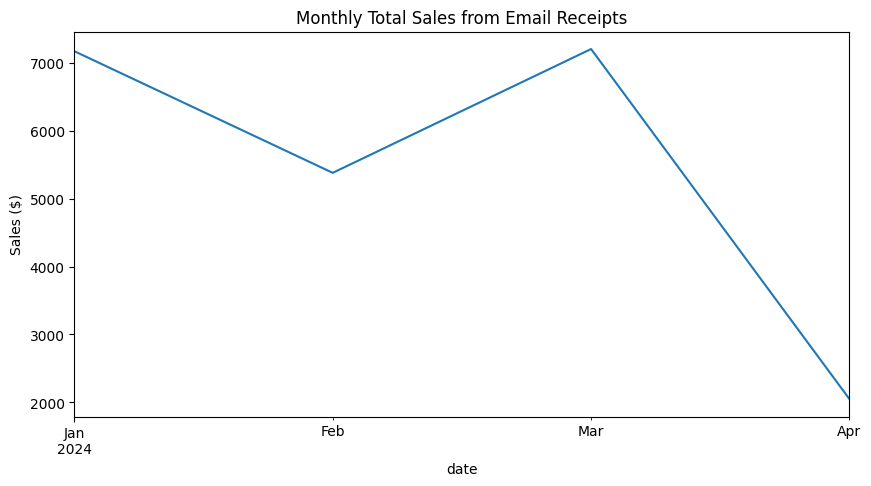

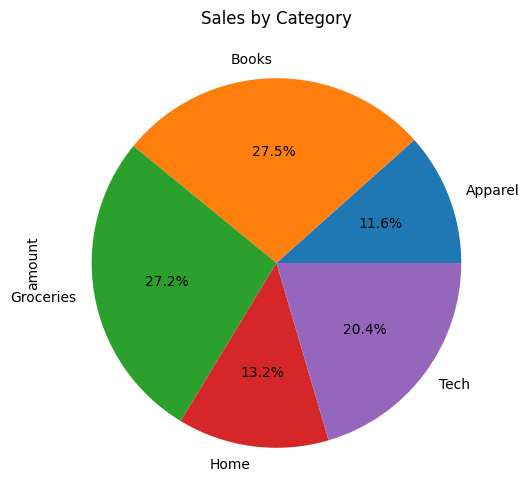


Correlation Matrix:
               amount  discount  item_price
amount      1.000000 -0.098001    0.098941
discount   -0.098001  1.000000    0.063877
item_price  0.098941  0.063877    1.000000


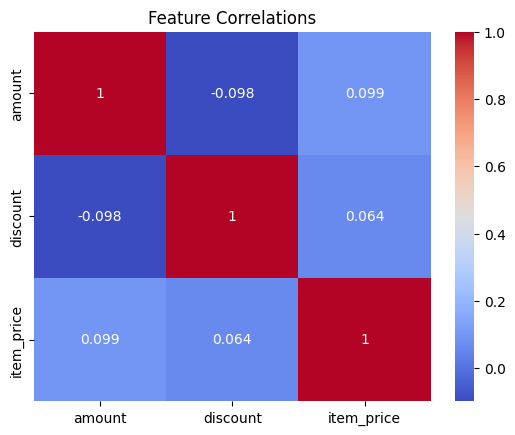


Outliers: 0 (0.0%)


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats

# Generate Sample Data
np.random.seed(42)  # Reproducibility
n_rows = 100
dates = pd.date_range(start='2024-01-01', periods=n_rows, freq='D')
merchants = np.random.choice(['Amazon', 'Walmart', 'Target', "Best Buy", "Kohl's"], n_rows)
amounts = np.random.uniform(10, 200, n_rows).round(2)
categories = np.random.choice(['Electronics', 'Clothing', 'Groceries', 'Books', 'Home'], n_rows)
user_ids = np.random.choice(['user_' + str(i).zfill(3) for i in range(1, 21)], n_rows)
discounts = np.random.uniform(0, 20, n_rows).round(2)

# Items as JSON
def gen_items(n_items=1):
    item_names = np.random.choice(['iPhone', 'T-Shirt', 'Milk', 'Novel', 'Lamp'], n_items)
    prices = np.random.uniform(5, 100, n_items).round(2)
    return json.dumps([{'name': name, 'price': price} for name, price in zip(item_names, prices)])

items_list = [gen_items(np.random.choice([1, 2, 3])) for _ in range(n_rows)]

df = pd.DataFrame({
    'date': dates, 'merchant': merchants, 'amount': amounts, 'items': items_list,
    'category': categories, 'user_id': user_ids, 'discount': discounts
})
df.to_csv('email_receipts_sample.csv', index=False)
print("Sample CSV generated with shape:", df.shape)
print(df.head())

# Load, Clean, and Structure
df = pd.read_csv('email_receipts_sample.csv', parse_dates=['date'])
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['discount'] = pd.to_numeric(df['discount'], errors='coerce')
df.dropna(subset=['date', 'merchant', 'amount'], inplace=True)

def parse_items(items_str):
    if pd.isna(items_str):
        return []
    try:
        return json.loads(items_str)
    except:
        return [{'name': items_str, 'price': np.nan}]

df['parsed_items'] = df['items'].apply(parse_items)
df_exploded = df.explode('parsed_items').reset_index(drop=True)

# Extract item price for better analysis
df_exploded['item_price'] = df_exploded['parsed_items'].apply(lambda x: x.get('price', np.nan) if isinstance(x, dict) else np.nan)

category_map = {'Electronics': 'Tech', 'Clothing': 'Apparel'}
df_exploded['std_category'] = df_exploded['category'].map(category_map).fillna(df_exploded['category'])

# Daily sales aggregation
daily_sales = df_exploded.groupby(['date', 'merchant']).agg({
    'amount': 'sum',
    'parsed_items': 'count'  # Units proxy
}).reset_index()
daily_sales.columns = ['date', 'merchant', 'total_sales', 'units_sold']
daily_sales.set_index('date', inplace=True)
print("\nDaily Sales Head:\n", daily_sales.head())

# User CLV summary
user_summary = df.groupby('user_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'date': lambda x: (x.max() - x.min()).days
}).round(2)
user_summary.columns = ['total_spend', 'avg_order', 'purchase_count', 'tenure_days']
user_summary['clv_proxy'] = (user_summary['total_spend'] / user_summary['tenure_days']) * 365
print("\nUser Summary Describe:\n", user_summary.describe())

# EDA
print("\n=== EDA Outputs ===")

# Descriptives
print("\nExploded Data Describe:\n", df_exploded.describe())
top_merchants = df_exploded.groupby('merchant')['amount'].sum().sort_values(ascending=False).head(5)
print("\nTop Merchants by Sales:\n", top_merchants)

# Time series & category

monthly_sales = daily_sales.resample('M')['total_sales'].sum()
plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='line')
plt.title('Monthly Total Sales from Email Receipts')
plt.ylabel('Sales ($)')
plt.show()

cat_sales = df_exploded.groupby('std_category')['amount'].sum()
plt.figure(figsize=(8, 6))
cat_sales.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sales by Category')
plt.show()

# Correlations
df_exploded['units_sold'] = 1  # Add for completeness, but use item_price for corr
corr_cols = ['amount', 'discount', 'item_price']  # More insightful
corr_df = df_exploded[corr_cols].corr()
print("\nCorrelation Matrix:\n", corr_df)
sns.heatmap(corr_df, annot=True, cmap='coolwarm')  # Uncomment for plot
plt.title('Feature Correlations')
plt.show()

# Outliers
df_exploded['z_amount'] = np.abs(stats.zscore(df_exploded['amount']))
outliers = df_exploded[df_exploded['z_amount'] > 3]
print(f"\nOutliers: {len(outliers)} ({len(outliers)/len(df_exploded)*100:.1f}%)")
if len(outliers) > 0:
    print("Outlier Sample:\n", outliers[['date', 'merchant', 'amount']].head())